# **NYU Tandon Bridge - BERT + Clustering**
https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Others:
https://github.com/ddangelov/Top2Vec
https://github.com/MaartenGr/BERTopic

In [ ]:
!pip install -q sentence-transformers
!pip install -q hdbscan
!pip install -q umap-learn

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 1.8MB 7.7MB/s 
     |████████████████████████████████| 1.2MB 36.3MB/s 
     |████████████████████████████████| 890kB 37.9MB/s 
     |████████████████████████████████| 2.9MB 38.1MB/s 
     |████████████████████████████████| 6.4MB 4.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import umap
import hdbscan
from sentence_transformers import SentenceTransformer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## **A. Data Preprocessing**

In [ ]:
path = "drive/MyDrive/data/tandon_bridge/"
# Import raw json data
with open(path+"data/preprocessed/transcripts.json", "r") as f:
    raw_transcript = json.load(f)

with open(path+"data/preprocessed/ppts.json", "r") as f:
    raw_ppt = json.load(f)

In [ ]:
# --- Data Preprocessing ------------------------------------------------------

# # Init Spacy
# nlp = spacy.load('en_core_web_lg')
# Define the stop words list
stop_words = set(stopwords.words('english'))
# Define stemmer
stemmer = PorterStemmer()
# Define lemmatizer
lemmatizer = WordNetLemmatizer()
# Define tf-idf vectorizer
vectorizer = TfidfVectorizer()


# Text preprocessing pipeline for the model
def text_preprocessing_1(lines):
    # Join lines into a string
    line = " ".join(lines)
    # Lowercase
    line = line.lower()
    # Remove symbols and numbers
    # line = re.sub(r'[^a-zA-Z]+', ' ', line)
    # Normalizing whitespaces
    line = line.split()
    # Remove stopwords and discards words of length < 3
    # line = [token for token in line if token not in stop_words and len(token) > 3]
    # Lemmatize the verbs and then stem
    # line = [stemmer.stem(lemmatizer.lemmatize(token, pos='v')) for token in line]
    # Join words to string
    line = ' '.join(line)
    return line


# Converts raw data to dataframe where each doc is a slide or transcript para
def convert_to_dataframe(raw_ppt, explode_col, text_col):
    df = pd.DataFrame(raw_ppt)
    df = df.explode(explode_col)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, pd.DataFrame(df[explode_col].to_list())], axis=1)
    df.drop(explode_col, axis=1, inplace=True)
    df[text_col] = df[text_col].apply(text_preprocessing_1)
    return df


# Apply conversion
df_ppt = convert_to_dataframe(raw_ppt, "ppt", "slide_text")
df_transcript = convert_to_dataframe(raw_transcript, "transcript", "data")

# Extract the text data
# data = df_ppt["slide_text"].to_list() + df_transcript["data"].to_list()
data = df_transcript["data"].to_list()
# data = df_ppt["slide_text"].to_list()

## B. Embeddings

In [ ]:
# Distilbert gives good speed + performance
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

# IMPORTANT: Must make sure that the data adheres the 512 token limit of BERT.
# ELSE SPLIT THE DOCS INTO MULTIPLE PARAGRAPHS 

100%|██████████| 245M/245M [00:12<00:00, 19.1MB/s]


## C. Clustering

It will help us in determining a suitable number of topics for the topic model.

### C.1. Dimensionality Reduction (UMAP)

In [ ]:
neighbors = 10

In [ ]:
umap_embeddings = umap.UMAP(n_neighbors=neighbors, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [ ]:
# data[1]

### C.2 Clustering (H-DBSCAN)

In [ ]:
cluster = hdbscan.HDBSCAN(min_cluster_size=neighbors,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
umap_data = umap.UMAP(n_neighbors=neighbors, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

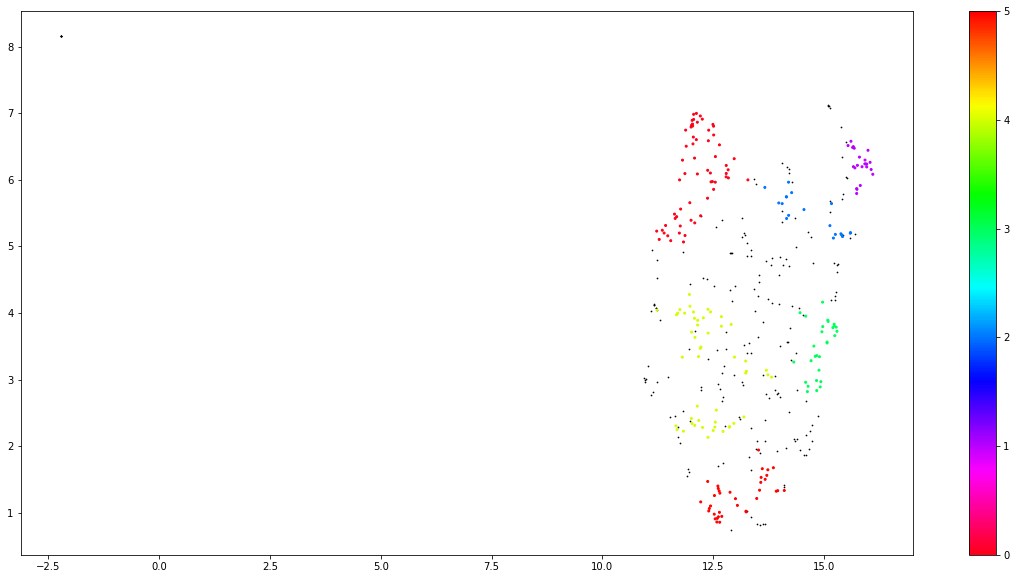

In [ ]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='black', s=0.5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
plt.colorbar()

### C.3. Classwise TF-IDF

In [ ]:
# Prepare df
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [ ]:
# Classwise tf-idf
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
# Apply tfidf and get scores for each word
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

## D. Topic Creation

In [ ]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 
topic_sizes.head(10)

,Topic,Size
0,-1,191
1,0,61
5,4,50
6,5,36
4,3,29
2,1,23
3,2,19


## TOPIC WORDS

In [ ]:
topic_words = {}
for i in range(len(top_n_words)-1):
  w = []
  for j in top_n_words[i]:
    w.append(j[0])
  topic_words[i] = w

In [ ]:
topic_words

{0: ['branch',
  'registers',
  'register',
  'stage',
  'fetch',
  'ram',
  'load',
  'cpu',
  'machine',
  'level',
  'segment',
  'controller',
  'address',
  'cache',
  'target',
  'offset',
  'pipeline',
  'instructions',
  'alu',
  'doubleword'],
 1: ['digits',
  'digit',
  'solutions',
  'quadratic',
  '375',
  '10',
  'equation',
  'word',
  'num',
  'real',
  'sum',
  'sorted',
  'fourteen',
  'count',
  'counting',
  'thirteen',
  'half',
  'squared',
  'decimal',
  'solution'],
 2: ['ileft',
  'grades',
  'iright',
  'merged',
  'balance',
  'average',
  'ind',
  'grade',
  'students',
  'merge',
  'ones',
  'tens',
  'factorial',
  'grouped',
  'octal',
  'ires',
  'numb',
  'dollars',
  'index',
  'deposit'],
 3: ['reference',
  'assumption',
  'ascending',
  'absolute',
  'true',
  'input',
  'negative',
  'odd',
  'digits',
  'induction',
  'power',
  'smaller',
  'statement',
  'passing',
  'sum',
  '26',
  'numbers',
  'minus',
  'positive',
  'representation'],
 4: ['